In [2]:
import pathlib

import dataset_generation

import pandas as pd
import pickle
from collections import Counter
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import groupby

# Functions

In [1]:
def load_pickle(path):
    with open(path, "rb") as fh:
        data = pickle.load(fh)
    return data    

In [11]:
def splitter(text):
    return ','.join(''.join(group) for key, group in groupby(text)) 

In [36]:
def top_feats_in_doc(Xtr, features, row_id, top_n=20):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray()) #Remove single-dimensional entries from the shape of an array. seleziono solo una porzione della matice degli score che è un vettore colonna---> così diventa una riga
    return top_tfidf_feats(row, features, top_n)

In [37]:
def top_tfidf_feats(row, features, top_n):
    ''' Get top n tfidf values and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]#column id
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [44]:
def plot_PCA(Xtr_embedded):
    colors = cm.jet(np.linspace(0, 1,len(labels)))
    fig, ax = plt.subplots(figsize=(5,5))

    for x, y, c in zip([x[0] for x in Xtr_embedded], [x[1] for x in Xtr_embedded], colors):
        plt.scatter(x, y, color=c)

    for i, txt in enumerate(labels):
        ax.annotate(txt, ([x[0] for x in Xtr_embedded][i],[x[1] for x in Xtr_embedded][i])) 

In [49]:
def text_similarity(source, target):  
    # calculate the cosine similarity comparing the vector of documents with the vector of each text
    source_vec = source
    
    target_vec = v.transform([target])[0].todense()
    
    return 1 - cosine(source_vec, target_vec)

In [47]:
#check the similarity between vocabularies
def cosine_similarity_preprocessing(seq_by_encoding,Xtr, label_column):
    labels=list(itertools.chain.from_iterable(set(label_column)))
    results_test = []
    class_combination=[]

    cos_similarity=pd.DataFrame()

    for i in range(len(seq_by_encoding)):
        source = np.squeeze(Xtr[i].toarray())
        for j in range(len(seq_by_encoding)):
            target = seq_by_encoding[j]
            class_combination.append(labels[i]+'|'+labels[j])
            results_test.append(text_similarity(source, target))
    cos_similarity['labels']=  class_combination
    cos_similarity['score']=  results_test
    return cos_similarity

In [52]:
def chunkstring(string, length):
    return (string[0+i:length+i] for i in range(0, len(string), length))

In [57]:
def lexical_density(x):
    return x['vocabulary'] / x['word_count']

In [66]:
def get_tfidf(seq_by_encoding, Xtr, features, n=20):
    rows=list()
    tfidf=list()
    scores=list()
    #apply tfidf for each class
    for row_id in range(len(seq_by_encoding)):
        rows.append(row_id)
        name=top_feats_in_doc(Xtr, features, row_id, top_n=20)

        lista_features=name["feature"].tolist()
        lista_scores=name["tfidf"].tolist()

        tfidf.append(lista_features)
        scores.append(lista_scores)
    df_tfidf=pd.DataFrame({"encoding":labels,"tfidf":tfidf,"scores":scores})
    return df_tfidf

In [7]:
def get_top_n_words(corpus, n, ngram_range):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Load data

sequence = original genomic sequence <br>
encoding = encoded genomic sequence <br>
The possible encodings for each base are as follows: <br>
U - UTR <br>
S - Start codon base <br>
E - Stop codon base <br>
C - Any non-start/stop codon base that is part of the coding sequence <br>
J - Slice junction donor/acceptor base <br>
I - Intron <br>
O - Intergenic, so not part of any of the above <br>

In [3]:
data_directory = pathlib.Path("data")

In [4]:
data = dataset_generation.load_data()

loading data...
data loaded


In [ ]:
"""
oload_pickle you need to install pickle5
!pip3 install pickle5

import pickle5 as pickle
with open('/content/drive/MyDrive/gene_calling/sequences_dataframe.pickle', "rb") as fh:
  data = pickle.load(fh)
"""

In [3]:
data=load_pickle("data/sequences_dataframe.pickle")

In [5]:
data.head()

,description,sequence,encoding
0,1,GGATCCGTTCGAAACAGGTTAGCCTACTATAATATAAGGATTGGAT...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,2,ATGGGCGAACGACGGGAATTGAACCCGCGATGGTGAATTCACAATC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
2,3,TATACCATGTACCCTCAACCTTAAAACCCTAAAACCTATACTATAA...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,4,ATGGTACGTATTACCTAAGTACGTAGGATCGTAAATGGGTTGAGAG...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
4,5,AAAACCATCTTTTTTTTTCAAATTCGTATTATCTGTATATGCCTAT...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [5]:
len(data['sequence'][0])

500000

In [6]:
len(data)

10917

In [8]:
set(list(data['encoding'][0]))

{'C', 'E', 'I', 'J', 'O', 'S'}

In [9]:
set(list(data['sequence'][0]))

{'A', 'C', 'G', 'T'}

In [10]:
data.tail()

,description,sequence,encoding
10912,10913,GCCGAACAGCCCTGCCGCCTGTGGCAGCGCGCCTCCTCCCGTTTTC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
10913,10914,AGCGAAGCACAACACGACCGCCGACACGATCGTGACCCTCTGAACA...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
10914,10915,TTCTTGATCCTTAAGCCGAACTCGTTTTGAGCCCGTCTCAAGAATC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
10915,10916,TCGATTGCTCCGTTAGCAGGGCATAGTGGTCACCCGAGTTAAGTAA...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
10916,10917,GTCTTGCACCTGAATGTTATTTGTTTCCCTAATTATCACATTTCTC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


The dataset is too large to train the model, we need to split it. We can create a subset of the original dataset or divide the original dataframe in more parts

### Subset 5% of original dataset <br>


In [7]:
subset_05_data=data.sample(int(len(data)*0.05)).reset_index()

In [8]:
subset_05_data.head()

,index,description,sequence,encoding
0,3514,3515,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,7200,7201,TAGTTTCATGTAAGAACAAGGTTAACACATAGATGTAGTGTGTACC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
2,9098,9099,GTACAGGGGCCGGCGTTCTCTGCCTGACGGCCGGACGGTCTGCGCC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,9237,9238,ATTCGGTTTACCTTCCAAAACCGGGTGTGACAGGCAGCCGACTGGG...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
4,5924,5925,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [43]:
len(subset_05_data)

545

In [9]:
#save subset
subset_05_data.to_pickle("./data/subset_05_data.pkl")

In [8]:
#load dataset
subset_05_data=load_pickle("data/subset_05_data.pkl")    
subset_05_data.head() 

,index,description,sequence,encoding
0,3514,3515,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,7200,7201,TAGTTTCATGTAAGAACAAGGTTAACACATAGATGTAGTGTGTACC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
2,9098,9099,GTACAGGGGCCGGCGTTCTCTGCCTGACGGCCGGACGGTCTGCGCC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,9237,9238,ATTCGGTTTACCTTCCAAAACCGGGTGTGACAGGCAGCCGACTGGG...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
4,5924,5925,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


### Divide the data dataframe

In [12]:
data1, data2, data3, data4, data5=np.array_split(data,5)

In [13]:
data1.to_csv('data/sequences_dataframe_part1.csv')
#data2.to_csv('data/sequences_dataframe_part2.csv')
#data3.to_csv('data/sequences_dataframe_part3.csv')
#data4.to_csv('data/sequences_dataframe_part4.csv')
#data5.to_csv('data/sequences_dataframe_part5.csv')
data1=pd.read_csv('data/sequences_dataframe_part1.csv')

In [14]:
data1.head()

,Unnamed: 0,description,sequence,encoding
0,0,1,GGATCCGTTCGAAACAGGTTAGCCTACTATAATATAAGGATTGGAT...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,1,2,ATGGGCGAACGACGGGAATTGAACCCGCGATGGTGAATTCACAATC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
2,2,3,TATACCATGTACCCTCAACCTTAAAACCCTAAAACCTATACTATAA...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,3,4,ATGGTACGTATTACCTAAGTACGTAGGATCGTAAATGGGTTGAGAG...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
4,4,5,AAAACCATCTTTTTTTTTCAAATTCGTATTATCTGTATATGCCTAT...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


## EDA by base

split each sequence by base and save them in a dataframe

In [10]:
d=pd.DataFrame()
d['sequence_base']=list(''.join(subset_05_data['sequence']))
d['encoding_base']=list(''.join(subset_05_data['encoding']))

In [11]:
d.head()

,sequence_base,encoding_base
0,N,O
1,N,O
2,N,O
3,N,O
4,N,O


In [21]:
# total numebr of available bases
len(subset_05_data)*500000

273000000

In [12]:
#the dataset is unbalanced
d.groupby('encoding_base').count()

,sequence_base
encoding_base,
C,4945522
E,11302
I,12845963
J,101035
O,254584869
S,11309


In [13]:
#count the bases belonging to the gene sequences
gene_count=d.loc[d['encoding_base'].isin(['C','E','I','J','S'])].count()

In [16]:
gene_count

sequence_base    17915131
encoding_base    17915131
dtype: int64

In [14]:
d.loc[d['encoding_base'].isin(['O'])].count()/gene_count
#more intergenic base than gene bases, unbalanced for two-class problem 

sequence_base    14.210606
encoding_base    14.210606
dtype: float64

In [15]:
d.groupby('sequence_base').count() #check IUPAC nomeclature

,encoding_base
sequence_base,
A,62026616
C,46690512
G,46625820
K,3
M,3
N,6944703
R,4
S,1
T,110212319


In [17]:
e_base=set(d['encoding_base'])

In [18]:
#distribution of bases by class
for idx,e in enumerate (e_base):
    print('\n')
    print(e)
    print(d[d['encoding_base']==str(e)].groupby('sequence_base').count())
    print('\n')



E
               encoding_base
sequence_base               
A                       5235
G                       2295
T                       3772




S
               encoding_base
sequence_base               
A                       3769
G                       3765
T                       3775




O
               encoding_base
sequence_base               
A                   57042713
C                   42977852
G                   42780187
K                          3
M                          3
N                    6940135
R                          4
S                          1
T                  104843952
W                         13
Y                          6




C
               encoding_base
sequence_base               
A                    1374248
C                    1137327
G                    1207814
N                        190
T                    1225943




J
               encoding_base
sequence_base               
A                      28181
C              

In [ ]:
#d.groupby(['encoding_base'])['sequence_base'].agg(count_base='sum').sort_values('count_base', ascending=False).reset_index()

In [19]:
# some bases characterize a specific class see W,Y for introgenic
d.groupby(['sequence_base','encoding_base']).count()

Empty DataFrame
Columns: []
Index: [(A, C), (A, E), (A, I), (A, J), (A, O), (A, S), (C, C), (C, I), (C, J), (C, O), (G, C), (G, E), (G, I), (G, J), (G, O), (G, S), (K, O), (M, O), (N, C), (N, I), (N, J), (N, O), (R, O), (S, O), (T, C), (T, E), (T, I), (T, J), (T, O), (T, S), (W, O), (Y, O)]

## Eda by sequence

The purpose of this kind of exploration is the possibility to use these subsequences as word in a sentence. In this way we can apply some widespread score like Tf-Idf and cosine similarity to check if the classes are well different from each other and they can be good for a multiclass problem

## split sequence when encoding base changes

In [20]:
subset_05_data.head()

,index,description,sequence,encoding
0,3514,3515,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,7200,7201,TAGTTTCATGTAAGAACAAGGTTAACACATAGATGTAGTGTGTACC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
2,9098,9099,GTACAGGGGCCGGCGTTCTCTGCCTGACGGCCGGACGGTCTGCGCC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,9237,9238,ATTCGGTTTACCTTCCAAAACCGGGTGTGACAGGCAGCCGACTGGG...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
4,5924,5925,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [6]:
set(list(subset_05_data['encoding'][1]))

{'C', 'E', 'I', 'J', 'O', 'S'}

In [7]:
len(subset_05_data['encoding'])

545

In [9]:
len(subset_05_data['encoding'][0])

500000

subset_05_data or data*

In [15]:
#split encoding when character changes
data1['encoding splitted']=data1['encoding'].apply(lambda x: ','.join(''.join(group) for key, group in groupby(x)))

In [16]:
#count the length of each chunks and transform them in an integer array
data1['encoding splitted length']=data1['encoding splitted'].apply(lambda x: ','.join(str(len(val)) for idx, val in enumerate(x.split(','))))   
data1['encoding splitted length']=data1['encoding splitted length'].apply(lambda x: [int(s) for s in x.split(',')])                                                               

In [17]:
#split sequence on encoding chunks                                                
sequence_splitted=[]
for idx, val in enumerate(data1['sequence']):
    sequence_splitted.append(','.join([val[sum(data1['encoding splitted length'][idx][:i]):sum(data1['encoding splitted length'][idx][:i+1])] for i in range(len(data1['encoding splitted length'][idx]))]))
data1['sequence splitted']=  sequence_splitted

In [18]:
data1.head(3)

,Unnamed: 0,description,sequence,encoding,encoding splitted,encoding splitted length,sequence splitted
0,0,1,GGATCCGTTCGAAACAGGTTAGCCTACTATAATATAAGGATTGGAT...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,"[11917, 3, 318, 3, 4614, 3, 390, 3, 13211, 3, ...",GGATCCGTTCGAAACAGGTTAGCCTACTATAATATAAGGATTGGAT...
1,1,2,ATGGGCGAACGACGGGAATTGAACCCGCGATGGTGAATTCACAATC...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,"[7016, 3, 180, 3, 380, 3, 105, 3, 20395, 3, 84...",ATGGGCGAACGACGGGAATTGAACCCGCGATGGTGAATTCACAATC...
2,2,3,TATACCATGTACCCTCAACCTTAAAACCCTAAAACCTATACTATAA...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,"[5338, 3, 249, 3, 5044, 3, 2025, 3, 125, 3, 20...",TATACCATGTACCCTCAACCTTAAAACCCTAAAACCTATACTATAA...


In [19]:
#put splitted sequence and encoding in a new dataframe
word_df=pd.concat([pd.Series(row['encoding splitted'].split(','), row['sequence splitted'].split(','))              
                    for _, row in data1.iterrows()]).reset_index()

In [20]:
word_df['encoding']=word_df[0]
word_df['genomic_sequence']=word_df['index']

word_df['encoding']=word_df['encoding'].apply(lambda x: list(itertools.chain.from_iterable(set(x)))[0])

In [21]:
word_df.head()

,index,0,encoding,genomic_sequence
0,GGATCCGTTCGAAACAGGTTAGCCTACTATAATATAAGGATTGGAT...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,O,GGATCCGTTCGAAACAGGTTAGCCTACTATAATATAAGGATTGGAT...
1,ATG,SSS,S,ATG
2,TTTCAGTTCGCTAAGTTTTCAAAGTCCAAAGAGCGCAGACTAGCCA...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,C,TTTCAGTTCGCTAAGTTTTCAAAGTCCAAAGAGCGCAGACTAGCCA...
3,TAA,EEE,E,TAA
4,AGGCAAAGAAAAAAGGGATCCGCCTCGAATCAAAACGTTCTTTCTT...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,O,AGGCAAAGAAAAAAGGGATCCGCCTCGAATCAAAACGTTCTTTCTT...


In [22]:
word_df = word_df.drop(0, 1)
word_df = word_df.drop('index', 1)

In [23]:
word_df.head()

,encoding,genomic_sequence
0,O,GGATCCGTTCGAAACAGGTTAGCCTACTATAATATAAGGATTGGAT...
1,S,ATG
2,C,TTTCAGTTCGCTAAGTTTTCAAAGTCCAAAGAGCGCAGACTAGCCA...
3,E,TAA
4,O,AGGCAAAGAAAAAAGGGATCCGCCTCGAATCAAAACGTTCTTTCTT...


In [25]:
#save subset
word_df.to_pickle("./data/word_df.pkl")

In [26]:
word_df=load_pickle('./data/word_df.pkl')    

## sequence distribution

In [19]:
word_df.groupby('encoding').count()

,genomic_sequence
encoding,
C,20580
E,3769
I,16852
J,33678
O,3752
S,3772


In [30]:
#dataset is made by sequences obtained by randomly cutting the sequence so we migth have a remainder of codons
#TODO delete them
word_df[word_df['encoding']=='E'].groupby('genomic_sequence').count()

,encoding
genomic_sequence,
A,2
AG,1
TAA,1469
TAG,890
TGA,1404
TTT,3


In [31]:
#dataset is made by sequences obtained by randomly cutting the large sequence so we can have some codons truncated
# in the last part of the sequence as A, AT TODO delete them

word_df[word_df['encoding']=='S'].groupby('genomic_sequence').count()

,encoding
genomic_sequence,
A,3
AT,1
ATG,3765
TTT,3


In [ ]:
#check duplicates
word_df.groupby('genomic_sequence')['genomic_sequence'].agg(count='count').sort_values('count', ascending=False)

In [ ]:
word_df[word_df['genomic_sequence'].str.startswith('AT')] 

In [ ]:
word_df[word_df['genomic_sequence'].str.endswith('AT')]

In [28]:
word_df['sequence_len']=word_df['genomic_sequence'].astype(str).apply(len)
word_df.head()

,encoding,genomic_sequence,sequence_len
0,O,GGATCCGTTCGAAACAGGTTAGCCTACTATAATATAAGGATTGGAT...,11917
1,S,ATG,3
2,C,TTTCAGTTCGCTAAGTTTTCAAAGTCCAAAGAGCGCAGACTAGCCA...,318
3,E,TAA,3
4,O,AGGCAAAGAAAAAAGGGATCCGCCTCGAATCAAAACGTTCTTTCTT...,4614


In [29]:
word_df.groupby(['encoding'])['sequence_len'].agg(seq_sum='sum').sort_values('seq_sum', ascending=False).reset_index()
#dataset unbalnced for 6 classes--> 3 group? 

,encoding,seq_sum
0,O,955695241
1,C,68618635
2,I,65955144
3,J,1404241
4,S,163382
5,E,163357


In [30]:
word_df.groupby(['encoding'])['sequence_len'].mean().sort_values( ascending=False)

encoding
O    16928.742711
I      281.597247
C      238.211176
J        3.000034
E        2.999247
S        2.998495
Name: sequence_len, dtype: float64

In [31]:
word_df['sequence_len'].describe()

count    1.155759e+06
mean     9.448337e+02
std      1.538325e+04
min      1.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.340000e+02
max      5.000000e+05
Name: sequence_len, dtype: float64

[Text(0, 0, 'O'),
 Text(1, 0, 'S'),
 Text(2, 0, 'C'),
 Text(3, 0, 'E'),
 Text(4, 0, 'J'),
 Text(5, 0, 'I')]

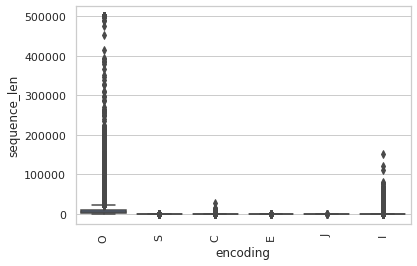

In [32]:
import seaborn as sns
sns.set(style="whitegrid")

g=sns.boxplot(x="encoding",y="sequence_len", data=word_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
#sns.set(rc={'figure.figsize':(30,8)})

In [33]:
#most frequent sequences
df_4=pd.Series(' '.join(word_df['genomic_sequence'].astype(str)).lower().split()).value_counts()[:10]
df_4.to_dict()

{'cag': 169342,
 'gta': 143663,
 'tag': 62949,
 'atg': 54401,
 'gtg': 45710,
 'gtt': 35583,
 'taa': 22746,
 'tga': 20127,
 'aag': 12108,
 'gtc': 6912}

### Sequence-Tf idf

In [39]:
v=TfidfVectorizer(ngram_range=(1, 1))
v

TfidfVectorizer()

In [62]:
labels=list(itertools.chain.from_iterable(set(word_df['encoding'])))
seq_by_encoding=[]
# join all the words related to the same class and consider them as corpus where apply tfidfvectorizer
for idx, i in enumerate(list(itertools.chain.from_iterable(set(word_df['encoding'])))):
    selected_seq=[x for x in word_df[word_df['encoding']==i]['genomic_sequence'].tolist()]
    seq_by_encoding.append(" ".join(selected_seq))
    print(i, len(selected_seq))

J 468075
E 54466
S 54488
I 234218
O 56454
C 288058


In [63]:
Xtr = v.fit_transform(seq_by_encoding)
features = v.get_feature_names()
Xtr.shape

(6, 310318)

In [67]:
#there some sequences that characterize the class (see E,J,S)
get_tfidf(seq_by_encoding, Xtr, features)

,encoding,tfidf,scores
0,J,"[cag, gta, tag, gtg, gtt, aag, gtc, gca, gag, ...","[0.7146265601414943, 0.6062952002391023, 0.216..."
1,E,"[taa, tga, tag, ttt, aa, ga, ta, ag, agttttcaa...","[0.6997309450108599, 0.6194617126935443, 0.355..."
2,S,"[atg, at, ttt, agttttcaagatgctctatgttatcacaaag...","[0.9999994117865821, 0.0009146549000522079, 0...."
3,I,[attgtgacttcaatattataaattagcagtcatatagttacatgt...,"[0.038424655333045905, 0.02955742717926608, 0...."
4,O,[cagcaacaacagtacaatgagagctccatattaaatgaaagggtt...,"[0.03701299607067426, 0.030844163392228546, 0...."
5,C,"[ag, tctggacgtggaaaaggtggcaaagtgaagggaaaggcaaa...","[0.03923132966543958, 0.038539590545537725, 0...."


In [ ]:
word_df[word_df['genomic_sequence'].str.contains('TTG')]['encoding']

### Sequence-PCA

plot the classes in the vector space

In [43]:
Xtr_embedded = PCA(n_components=2).fit_transform(Xtr.todense())
Xtr_embedded.shape

(6, 2)

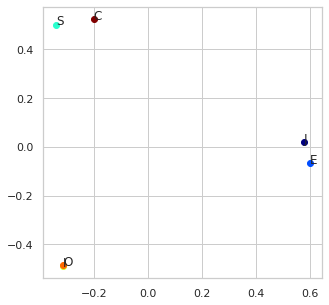

In [45]:
plot_PCA(Xtr_embedded)

### Sequence-Cosine similarity

In [50]:
cosine_similarity_preprocessing(seq_by_encoding,Xtr, word_df['encoding'])

,labels,score
0,J|J,1.000000e+00
1,J|E,7.726340e-02
2,J|S,1.793822e-05
3,J|I,0.000000e+00
4,J|O,2.134861e-08
5,J|C,1.343828e-02
6,E|J,7.726340e-02
7,E|E,1.000000e+00
8,E|S,4.674835e-07
9,E|I,0.000000e+00


## Cut the Sequence by a fixed length

In [51]:
word_df['sequence_len'].describe()

count    1.155759e+06
mean     9.448337e+02
std      1.538325e+04
min      1.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.340000e+02
max      5.000000e+05
Name: sequence_len, dtype: float64

In [53]:
word_df['sequence_splitted'] = word_df['genomic_sequence'].apply(lambda x: ",".join(list(chunkstring(x, 3))).replace(',', ' '))

In [54]:
word_df.head()

,encoding,genomic_sequence,sequence_len,sequence_splitted
0,O,GGATCCGTTCGAAACAGGTTAGCCTACTATAATATAAGGATTGGAT...,11917,GGA TCC GTT CGA AAC AGG TTA GCC TAC TAT AAT AT...
1,S,ATG,3,ATG
2,C,TTTCAGTTCGCTAAGTTTTCAAAGTCCAAAGAGCGCAGACTAGCCA...,318,TTT CAG TTC GCT AAG TTT TCA AAG TCC AAA GAG CG...
3,E,TAA,3,TAA
4,O,AGGCAAAGAAAAAAGGGATCCGCCTCGAATCAAAACGTTCTTTCTT...,4614,AGG CAA AGA AAA AAG GGA TCC GCC TCG AAT CAA AA...


In [ ]:
#check duplicates
word_df.groupby('sequence_splitted')['sequence_splitted'].agg(count='count').sort_values('count', ascending=False)

In [55]:
word_df['word_count'] = word_df['sequence_splitted'].apply(lambda x: len(str(x).split(' '))) 

In [56]:
word_df['vocabulary'] = word_df['sequence_splitted'].apply(lambda x: len(set(str(x).split(' '))))

word_df

,encoding,genomic_sequence,sequence_len,sequence_splitted,word_count,vocabulary
0,O,GGATCCGTTCGAAACAGGTTAGCCTACTATAATATAAGGATTGGAT...,11917,GGA TCC GTT CGA AAC AGG TTA GCC TAC TAT AAT AT...,3973,65
1,S,ATG,3,ATG,1,1
2,C,TTTCAGTTCGCTAAGTTTTCAAAGTCCAAAGAGCGCAGACTAGCCA...,318,TTT CAG TTC GCT AAG TTT TCA AAG TCC AAA GAG CG...,106,46
3,E,TAA,3,TAA,1,1
4,O,AGGCAAAGAAAAAAGGGATCCGCCTCGAATCAAAACGTTCTTTCTT...,4614,AGG CAA AGA AAA AAG GGA TCC GCC TCG AAT CAA AA...,1538,64
...,...,...,...,...,...,...
1155754,O,TAATTCAAAATGAAAAAATAATAAACATGGAAGGCATAGGCCAAGG...,500000,TAA TTC AAA ATG AAA AAA TAA TAA ACA TGG AAG GC...,166667,65
1155755,O,AATGGCAATCTAATTAGATTGAACAGTCGCTCGGTTATGAATGTCG...,500000,AAT GGC AAT CTA ATT AGA TTG AAC AGT CGC TCG GT...,166667,65
1155756,O,GACCAGTACGGGACCAGTACGGGACCGAGTATGGAACCGAGTACGG...,500000,GAC CAG TAC GGG ACC AGT ACG GGA CCG AGT ATG GA...,166667,26
1155757,O,TTGAACACAGTTTGATTGGAAATTTTATTACGAGCTCAGTGAGGTA...,500000,TTG AAC ACA GTT TGA TTG GAA ATT TTA TTA CGA GC...,166667,63


In [58]:
#lexical density measures how much eterogeneus is the vocabulary in each instance

word_df['lexical density'] = word_df.apply(lexical_density, axis=1)
word_df.head()

,encoding,genomic_sequence,sequence_len,sequence_splitted,word_count,vocabulary,lexical density
0,O,GGATCCGTTCGAAACAGGTTAGCCTACTATAATATAAGGATTGGAT...,11917,GGA TCC GTT CGA AAC AGG TTA GCC TAC TAT AAT AT...,3973,65,0.016360
1,S,ATG,3,ATG,1,1,1.000000
2,C,TTTCAGTTCGCTAAGTTTTCAAAGTCCAAAGAGCGCAGACTAGCCA...,318,TTT CAG TTC GCT AAG TTT TCA AAG TCC AAA GAG CG...,106,46,0.433962
3,E,TAA,3,TAA,1,1,1.000000
4,O,AGGCAAAGAAAAAAGGGATCCGCCTCGAATCAAAACGTTCTTTCTT...,4614,AGG CAA AGA AAA AAG GGA TCC GCC TCG AAT CAA AA...,1538,64,0.041612


In [59]:
word_df.groupby(['encoding'])['word_count'].agg(word_sum='sum').sort_values('word_sum', ascending=False).reset_index()

,encoding,word_sum
0,O,318583849
1,C,22951442
2,I,22063548
3,J,468085
4,S,54488
5,E,54466


In [60]:
word_df.groupby(['encoding'])['word_count'].agg(word_mean='mean').sort_values('word_mean', ascending=False).reset_index()

,encoding,word_mean
0,O,5643.246696
1,I,94.200907
2,C,79.676461
3,J,1.000021
4,E,1.000000
5,S,1.000000


In [ ]:
#most frequent sequences
df_4=pd.Series(' '.join(word_df['sequence_splitted'].astype(str)).lower().split()).value_counts()[:10]
df_4.to_dict()

In [77]:
list(word_df['encoding'].value_counts().index)

['J', 'C', 'I', 'S', 'E', 'O']

In [61]:
#group classes?
labels=list(itertools.chain.from_iterable(set(word_df['encoding'])))
seq_by_encoding=[]
for  i in list(word_df['encoding'].value_counts().index):
    selected_seq=[x for x in word_df[word_df['encoding']==i]['sequence_splitted'].tolist() if x is not None]
    seq_by_encoding.append(" ".join(selected_seq))
    print(i, len(selected_seq))

J 468075
C 288058
I 234218
O 56454
S 54488
E 54466


In [79]:
v = TfidfVectorizer(ngram_range=(1, 3))  #v=TfidfVectorizer(ngram_range=(1, 1))
Xtr = v.fit_transform(seq_by_encoding)
features = v.get_feature_names()
Xtr.shape

(6, 297605)

In [ ]:
get_tfidf(seq_by_encoding, Xtr, features)

In [ ]:
Xtr_embedded = PCA(n_components=2).fit_transform(Xtr.todense())
Xtr_embedded.shape
plot_PCA(Xtr_embedded)

In [83]:
#cosine similarity
cosine_similarity_preprocessing(seq_by_encoding,Xtr, word_df['encoding'])


### Unigrams, bigrams, trigrams

In [ ]:
common_words = get_top_n_words(word_df['sequence_splitted'], 20, (1,1))
for word, freq in common_words:
    print(word, freq)

In [ ]:
common_words = get_top_n_words(word_df['sequence_splitted'], 20, (2,2))
for word, freq in common_words:
    print(word, freq)

In [ ]:
common_words = get_top_n_words(word_df['sequence_splitted'], 20, (3,3))
for word, freq in common_words:
    print(word, freq)

## save/load word_df

In [68]:
#save subset
word_df.to_pickle("./data/word_df_metrics.pkl")

In [ ]:
word_df.to_csv('./data/word_df_data1.csv')
word_df=pd.read_csv('./data/word_df_data1.csv')

In [ ]:
"""
TO DO: 
preprocessing
cleaning less frequent words
cut the sequence 
"""